In [1]:
import json
import pandas as pd
import re
import string

file_path = 'Dataset/DiverseVul_AST_secondo.json'
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

# Split dataset

In [4]:
import pandas as pd
from sklearn.utils import resample

# Dividi il dataframe in due parti: target=0 e target=1
df_target_0 = df[df['target'] == 0]
df_target_1 = df[df['target'] == 1]

# Conta il numero di entry per ciascun target
count_target_0 = len(df_target_0)
count_target_1 = len(df_target_1)

# Calcola il numero di campioni desiderati, tenendo conto delle dimensioni dei gruppi
total_samples = min(count_target_0 / (2/3), count_target_1 / (1/3))
n_samples_target_1 = int(total_samples * (1/3))
n_samples_target_0 = int(total_samples * (2/3))

# Esegui il campionamento casuale
df_target_0_downsampled = resample(df_target_0, 
                                   replace=False,  # campionamento senza ripetizione
                                   n_samples=n_samples_target_0, 
                                   random_state=42)  # per riproducibilità

df_target_1_downsampled = resample(df_target_1, 
                                   replace=False, 
                                   n_samples=n_samples_target_1, 
                                   random_state=42)

# Combina i campioni
df_downsampled = pd.concat([df_target_0_downsampled, df_target_1_downsampled])

# Mescola il dataset
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Ora 'df_downsampled' è il dataset con le proporzioni desiderate
print(df_downsampled['target'].value_counts(normalize=True))



target
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df=df_downsampled.copy()
X = df['func']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(len(X_train))
print(len(X_test))
#Creazione del pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Trasformazione del testo in feature
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
])

12756
3189


# Training

In [8]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rf',
                 RandomForestClassifier(n_estimators=10, random_state=42))])

# Valutazione

In [9]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2126
           1       0.48      0.19      0.27      1063

    accuracy                           0.66      3189
   macro avg       0.59      0.54      0.52      3189
weighted avg       0.62      0.66      0.61      3189

Accuracy: 0.6622765757290687


# Matrice

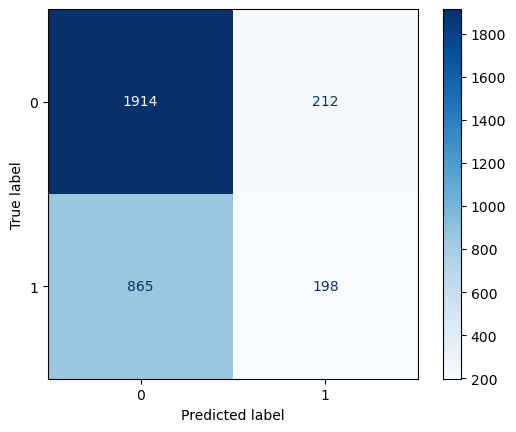

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()